In [1]:
import site, pathlib, subprocess, sys
sys.path.insert(0,"/home/mt622/GitHubRepos/FractionalBrownianMotion")
repo_root = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], text=True
).strip()
pth_dir = pathlib.Path(site.getsitepackages()[0])
(pth_dir / "namerepo_root.pth").write_text(repo_root + "\n")
print("Wrote", pth_dir / "namerepo_root.pth")

Wrote /home/mt622/GitHubRepos/FractionalBrownianMotion/.venv/lib/python3.10/site-packages/namerepo_root.pth


In [2]:
import pickle
from configs import project_config
import numpy as np
import torch
import os
from tqdm import tqdm
from src.classes.ClassConditionalStbleTgtMarkovianPostMeanDiffTrainer import \
    ConditionalStbleTgtMarkovianPostMeanDiffTrainer
from src.generative_modelling.data_processing import train_and_save_recursive_diffusion_model
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching
from utils.data_processing import init_experiment, cleanup_experiment
from utils.math_functions import generate_fQuadSin
from utils.resource_logger import ResourceLogger

In [3]:
# Data parameters
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T64_H05_tl_110data_StbleTgt import get_config
config = get_config()

In [4]:
assert (config.hurst == 0.5)
assert (config.early_stop_idx == 0)
assert (config.tdata_mult == 110)
#assert (config.sin_space_scale == 25.)
assert (config.feat_thresh == 1./500.)
print(config.scoreNet_trained_path, config.dataSize)
rng = np.random.default_rng()
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)


/home/mt622/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtNFMReg_fQuadSinHF_VPSDE_T64_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT1562e-02_05a_004b_250c_MLP_H4_CUp20_tl110 40000


In [5]:
model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
entered = False
for file in os.listdir(model_dir):
    if config.scoreNet_trained_path in os.path.join(model_dir, file) and ("EE" in file and "Trk" not in file) and "fQuad" in file:
        good = ConditionalMarkovianTSPostMeanScoreMatching(
    *config.model_parameters)
        print(file)
        entered = True
        good.load_state_dict(torch.load(os.path.join(model_dir, file)))
assert entered

trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtNFMReg_fQuadSinHF_VPSDE_T64_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT1562e-02_05a_004b_250c_MLP_H4_CUp20_tl110_EENEp2461


In [6]:
import torch.nn.functional as F
def experiment_MLP_1D_drifts(config, es,Xs, good, onlyGauss=False):
    print("Beta Min : ", config.beta_min)
    if config.has_cuda:
        device = 0#int(os.environ["LOCAL_RANK"])
    else:
        print("Using CPU\n")
        device = torch.device("cpu")
    Xs = torch.Tensor(Xs).to(device)
    good = good.to(device)
    diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
    ts_step = config.deltaT
    print(config.scoreNet_trained_path)
    Xshape = 256 #config.ts_length
    num_taus = 10

    num_diff_times = config.max_diff_steps
    Ndiff_discretisation = config.max_diff_steps
    diffusion_times = torch.linspace(start=config.sample_eps, end=config.end_diff_time,
                                     steps=Ndiff_discretisation).to(device)

    features_tensor = torch.stack([Xs for _ in range(1)], dim=0).reshape(Xshape * 1, 1, -1).to(device)
    vec_Z_taus = diffusion.prior_sampling(shape=(Xshape * num_taus, 1, config.ts_dims)).to(device)

    # ts = []
    es = num_diff_times - es
    final_vec_mu_hats = np.zeros(
        (Xshape, es, num_taus, config.ts_dims))  # Xvalues, DiffTimes, Ztaus, Ts_Dims
    
    ts = []
    # mu_hats_mean = np.zeros((tot_num_feats, num_taus))
    # mu_hats_std = np.zeros((tot_num_feats, num_taus))
    good.eval()
    insert_idx=-1
    for difftime_idx in tqdm(np.arange(num_diff_times - 1, num_diff_times - es - 1, -1)): #difftime_idx >= num_diff_times - es:
        d = diffusion_times[Ndiff_discretisation - (num_diff_times - 1 - difftime_idx) - 1].to(device)
        diff_times = torch.stack([d for _ in range(Xshape)]).reshape(Xshape * 1).to(device)
        eff_times = diffusion.get_eff_times(diff_times=diff_times).unsqueeze(-1).unsqueeze(-1).to(device)
        vec_diff_times = torch.stack([diff_times for _ in range(num_taus)], dim=0).reshape(num_taus * Xshape)
        vec_eff_times = torch.stack([eff_times for _ in range(num_taus)], dim=0).reshape(num_taus * Xshape, 1, 1)
        vec_conditioner = torch.stack([features_tensor for _ in range(num_taus)], dim=0).reshape(
            num_taus * Xshape,
            1, -1)
        with torch.no_grad():
            if onlyGauss:
                scoreEval_vec_Z_taus = torch.randn_like(vec_Z_taus).to(device)
            else:
                scoreEval_vec_Z_taus = vec_Z_taus
            vec_predicted_score = good.forward(inputs=scoreEval_vec_Z_taus, times=vec_diff_times, conditioner=vec_conditioner,
                                             eff_times=vec_eff_times)
        
        beta_taus = torch.exp(-0.5 * eff_times[0, 0, 0]).to(device)
        sigma_taus = torch.pow(1. - torch.pow(beta_taus, 2), 0.5).to(device)
        sigma2_taus=torch.pow(1. - torch.pow(beta_taus, 2), 1.).to(device)
        predicted_score = -scoreEval_vec_Z_taus/sigma2_taus + (beta_taus/sigma2_taus)*vec_predicted_score
        vec_scores, vec_drift, vec_diffParam = diffusion.get_conditional_reverse_diffusion(x=vec_Z_taus,
                                                                                           predicted_score=predicted_score,
                                                                                           diff_index=torch.Tensor(
                                                                                               [int((
                                                                                                       num_diff_times - 1 - difftime_idx))]).to(
                                                                                               device),
                                                                                           max_diff_steps=Ndiff_discretisation)

        if "PM" in config.scoreNet_trained_path:
            final_mu_hats = (beta_taus*scoreEval_vec_Z_taus / (sigma2_taus)) + ((
                                                                            (torch.pow(sigma_taus, 2) + (
                                                                                    torch.pow(beta_taus * config.diffusion,
                                                                                            2) * ts_step)) / (
                                                                                    ts_step * sigma2_taus)) * vec_predicted_score)            
        else:
            final_mu_hats = (scoreEval_vec_Z_taus / (ts_step * beta_taus)) + ((
                                                                            (sigma2_taus + (
                                                                                    torch.pow(beta_taus * config.diffusion,
                                                                                            2) * ts_step)) / (
                                                                                    ts_step * beta_taus)) * vec_scores)

        assert (final_mu_hats.shape == (num_taus * Xshape, 1, config.ts_dims))
        means = final_mu_hats.reshape((num_taus, Xshape, config.ts_dims))

        # print(vec_Z_taus.shape, vec_scores.shape)
        final_vec_mu_hats[:, insert_idx,:, :] = means.permute((1, 0, 2)).cpu().numpy()
        vec_z = torch.randn_like(vec_drift).to(device)
        vec_Z_taus = vec_drift + vec_diffParam * vec_z
        insert_idx -=1
    assert (final_vec_mu_hats.shape == (Xshape, es, num_taus, config.ts_dims))
    return final_vec_mu_hats

In [7]:
Xshape = 256#config.ts_length
Xs = torch.linspace(-1.5, 1.5, steps=Xshape)
true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(config.sin_space_scale * Xs))
true_drifts = true_drifts[:, np.newaxis].numpy()

In [8]:
remote_file_path = project_config.ROOT_DIR+"data/" #/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/"
remote_file_path

'/home/mt622/GitHubRepos/FractionalBrownianMotion/data/'

In [9]:
es=0
DNonGauss = experiment_MLP_1D_drifts(good=good, es=es, Xs=Xs, config=config, onlyGauss=False)
np.save(remote_file_path + "QuadSinHF_optimal_tau_experiment_DNonGauss_T64.npy", DNonGauss)

DGauss = experiment_MLP_1D_drifts(good=good,es=es, Xs=Xs, config=config, onlyGauss=True)
np.save(remote_file_path + "QuadSinHF_optimal_tau_experiment_DGauss_T64.npy", DGauss)

Beta Min :  0.0
/home/mt622/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtNFMReg_fQuadSinHF_VPSDE_T64_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT1562e-02_05a_004b_250c_MLP_H4_CUp20_tl110


100%|██████████| 10000/10000 [00:52<00:00, 190.45it/s]


Beta Min :  0.0
/home/mt622/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_ST_0002FTh_PM_MLP_2LFac_NSTgtNFMReg_fQuadSinHF_VPSDE_T64_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT1562e-02_05a_004b_250c_MLP_H4_CUp20_tl110


100%|██████████| 10000/10000 [00:50<00:00, 198.85it/s]


In [10]:
def compute_MSE_CIs(muhats):
    estimates = np.mean(muhats, axis=2)
    errors = estimates - true_drifts[:, np.newaxis,:]
    deltas = (muhats) - estimates[:,:, np.newaxis,:]
    #norms = np.sqrt(np.sum(np.power(errors,2), axis=-1, keepdims=True))
    us = errors#/norms
    us = 2*us.transpose((1,0,2))
    deltas = deltas.transpose((1,0,2,3))
    val=np.mean(np.sum(us[:, :, np.newaxis, :]*deltas,axis=-1) ,axis=1)
    std = np.std(val, axis=-1)
    mse = np.mean((np.sum(np.power(errors,2), axis=-1)), axis=0)
    return mse, std

In [11]:
DNonGauss=np.load(remote_file_path + "QuadSinHF_optimal_tau_experiment_DNonGauss_T64.npy", allow_pickle=True)
DGauss=np.load(remote_file_path + "QuadSinHF_optimal_tau_experiment_DGauss_T64.npy", allow_pickle=True)
NonGauss_mse, NonGauss_std = compute_MSE_CIs(muhats=DNonGauss)
Gauss_mse, Gauss_std = compute_MSE_CIs(muhats=DGauss)


[0.001      0.00109991 0.00119982 ... 0.99980018 0.99990009 1.        ]


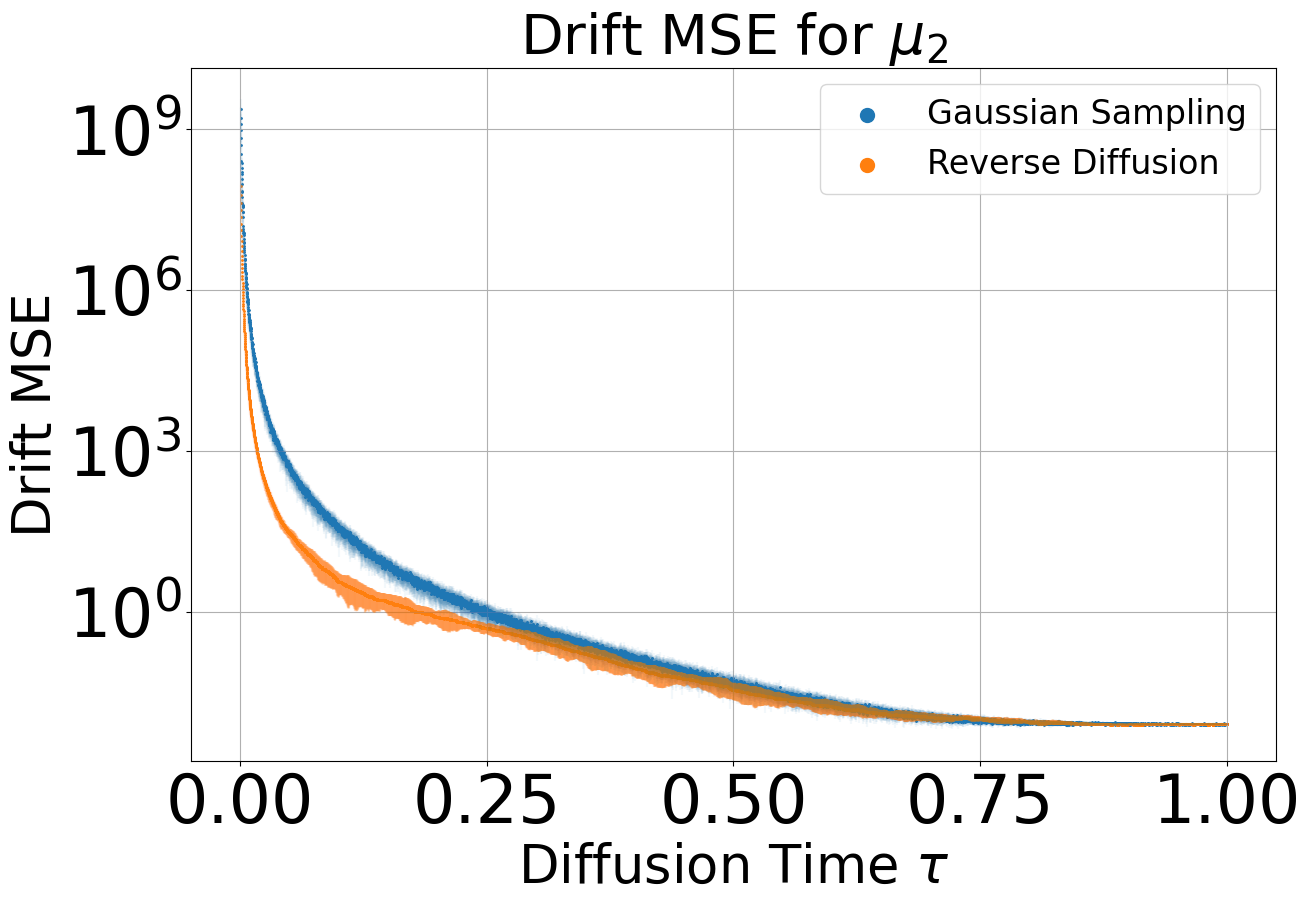

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,9))
startidx=0
diff_times = np.linspace(config.train_eps, 1, config.max_diff_steps)
print(diff_times)
plt.scatter(diff_times[startidx:],Gauss_mse[startidx:],s=1, label="Gaussian Sampling")
plt.errorbar(x=diff_times[startidx:],y=Gauss_mse[startidx:], yerr=Gauss_std[startidx:], alpha=0.05)
plt.scatter(diff_times[startidx:],NonGauss_mse[startidx:],s=1, label="Reverse Diffusion")
plt.errorbar(x=diff_times[startidx:],y=NonGauss_mse[startidx:], yerr=NonGauss_std[startidx:], alpha=0.05)
plt.yscale("log")
plt.title("Drift MSE for $\mu_2$", fontsize=40)
plt.xlabel(rf"Diffusion Time $\tau$", fontsize=38)
plt.ylabel("Drift MSE",fontsize=38)
ax.tick_params(labelsize=48)
plt.grid(True)
plt.legend(markerscale=10,fontsize=24)
plt.show()
plt.close()

[0.001      0.00109991 0.00119982 ... 0.99980018 0.99990009 1.        ]


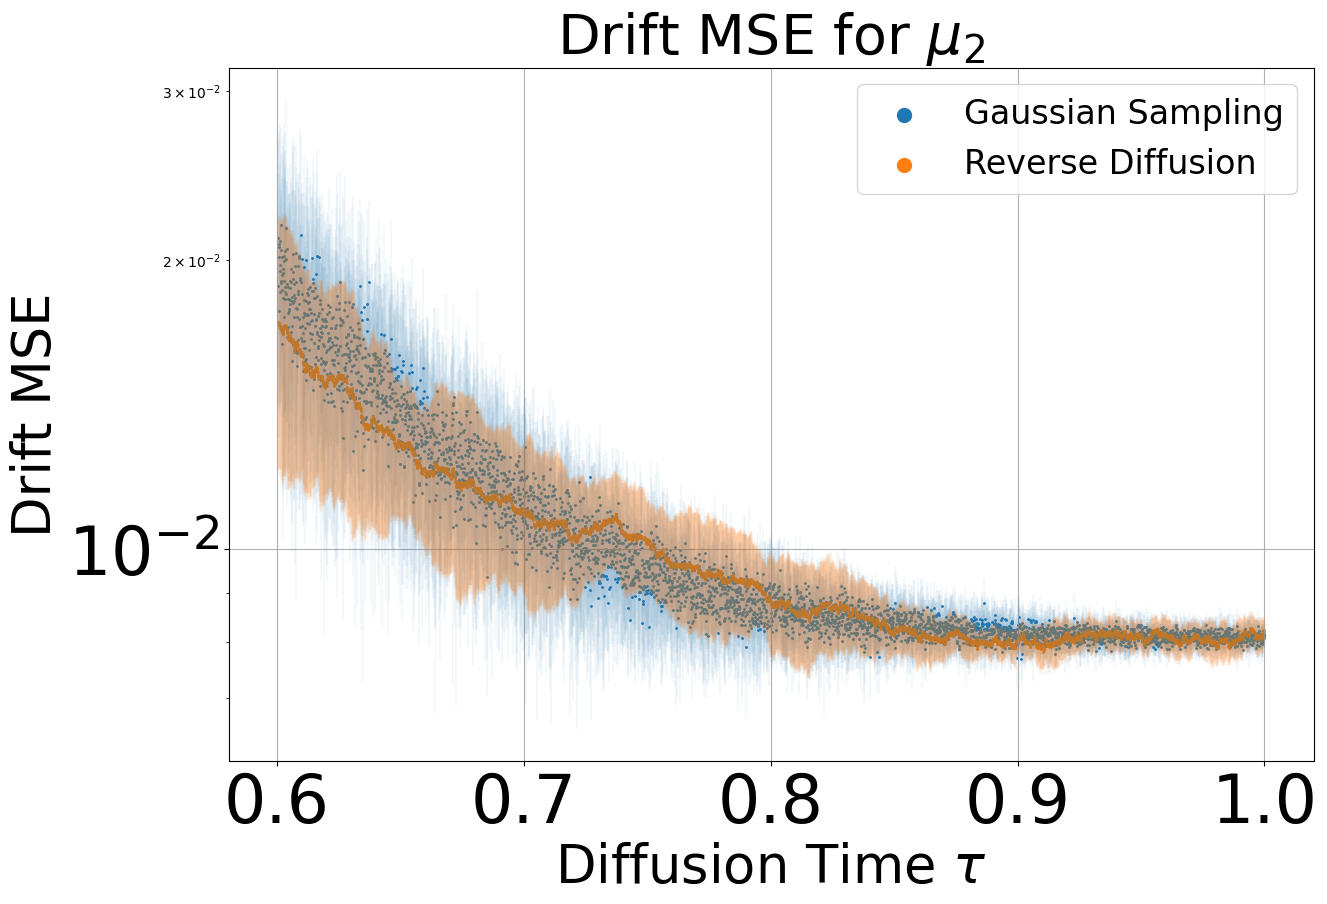

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,9))
startidx=6000
diff_times = np.linspace(config.train_eps, 1, config.max_diff_steps)
print(diff_times)
plt.scatter(diff_times[startidx:],Gauss_mse[startidx:],s=1, label="Gaussian Sampling")
plt.errorbar(x=diff_times[startidx:],y=Gauss_mse[startidx:], yerr=Gauss_std[startidx:], alpha=0.05)
plt.scatter(diff_times[startidx:],NonGauss_mse[startidx:],s=1, label="Reverse Diffusion")
plt.errorbar(x=diff_times[startidx:],y=NonGauss_mse[startidx:], yerr=NonGauss_std[startidx:], alpha=0.05)
plt.yscale("log")
plt.title("Drift MSE for $\mu_2$", fontsize=40)
plt.xlabel(rf"Diffusion Time $\tau$", fontsize=38)
plt.ylabel("Drift MSE",fontsize=38)
ax.tick_params(labelsize=48)
plt.grid(True)
plt.legend(markerscale=10,fontsize=24)
plt.show()
plt.close()

0.00817300297125137


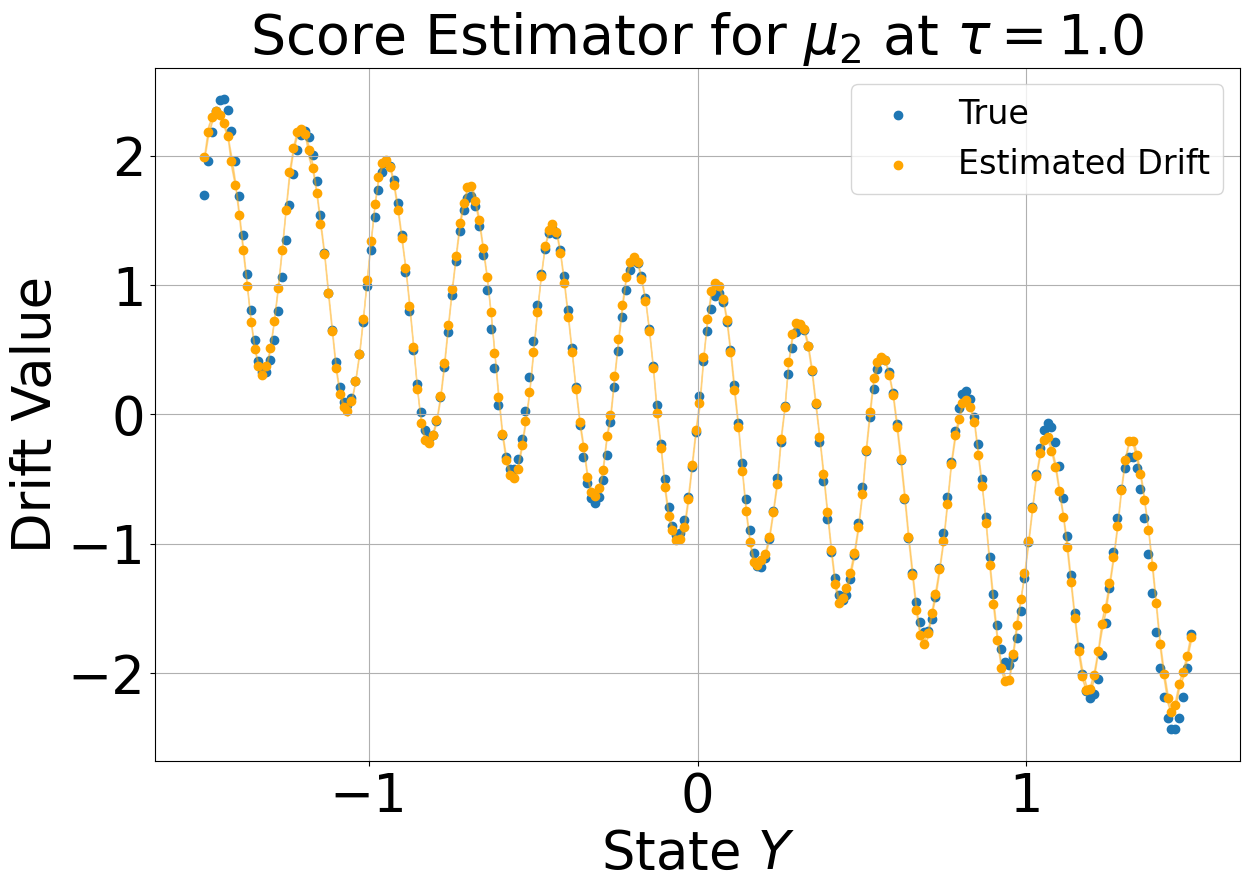

In [14]:
fig, ax = plt.subplots(figsize=(14,9))
tauidx = 9999
tau_NonGauss = DNonGauss[:, tauidx, :, :]
estimate = np.mean(tau_NonGauss, axis=1)
for d in range(tau_NonGauss.shape[-1]):
    plt.scatter(Xs, true_drifts[:, d], color="red", label="True Drift")
    plt.scatter(Xs, estimate[:, d], label="Estimated Drift",color="red")
    lowq_tau_errors = np.quantile(tau_NonGauss[:,:, d], q=0.1, axis=-1)
    highq_tau_errors = np.quantile(tau_NonGauss[:,:,d], q=0.9, axis=-1)
    plt.fill_between(Xs,lowq_tau_errors, highq_tau_errors, alpha=0.4,color="red")
    print((np.mean(np.sum(np.power(estimate-true_drifts,2), axis=-1))))
plt.title(rf"Score Estimator for $\mu_2$ at $\tau=${round(diff_times[tauidx],3)}", fontsize=40)
plt.grid(True)
plt.legend(fontsize=24)
ax.tick_params(labelsize=38)
plt.ylabel("Drift Value", fontsize=38)
plt.xlabel(rf"State $Y$", fontsize=38)
plt.show()
plt.close()

3.609040690712418


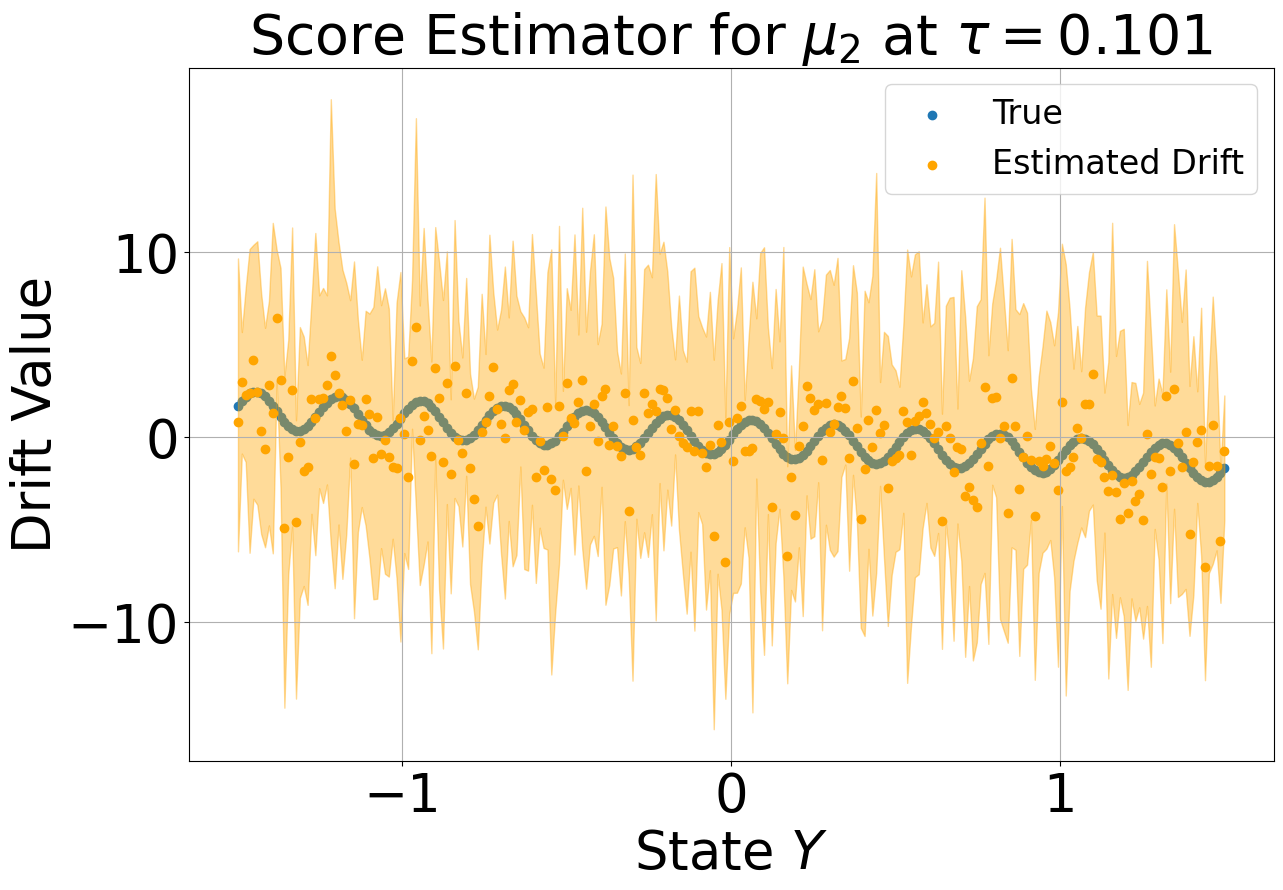

In [15]:
fig, ax = plt.subplots(figsize=(14,9))
tauidx = 1000
tau_NonGauss = DNonGauss[:, tauidx, :, :]
estimate = np.mean(tau_NonGauss, axis=1)
for d in range(tau_NonGauss.shape[-1]):
    plt.scatter(Xs, true_drifts[:, d], color="red", label="True Drift")
    plt.scatter(Xs, estimate[:, d], label="Estimated Drift",color="blue")
    lowq_tau_errors = np.quantile(tau_NonGauss[:,:, d], q=0.1, axis=-1)
    highq_tau_errors = np.quantile(tau_NonGauss[:,:,d], q=0.9, axis=-1)
    plt.fill_between(Xs,lowq_tau_errors, highq_tau_errors, alpha=0.4,color="blue")
    print((np.mean(np.sum(np.power(estimate-true_drifts,2), axis=-1))))
plt.title(rf"Score Estimator for $\mu_2$ at $\tau=${round(diff_times[tauidx],3)}", fontsize=40)
plt.grid(True)
plt.legend(fontsize=24)
ax.tick_params(labelsize=38)
plt.ylabel("Drift Value", fontsize=38)
plt.xlabel(rf"State $Y$", fontsize=38)
plt.show()
plt.close()